# White noise object Phase Retrieval

> Georgios Varnavides | Oct 24 2025  
>
> Sample: white-noise object  
> Sampling conditions:2 A^-1 max-scattering angle, Nyquist sampling  
> Imaging conditions: 1 A^-1 semiangle, 200 A defocus, 100 A stig 

In [1]:
import quantem as em
import numpy as np

In [2]:
dataset = em.core.io.load("../data/white-noise-object_defocus+stig.zip")
dataset

Dataset(shape=(96, 96, 96, 96), dtype=float64, name='4D-STEM dataset')
  sampling: [0.25       0.25       0.04166667 0.04166667]
  units: ['A', 'A', 'A^-1', 'A^-1']
  signal units: 'arb. units'

In [3]:
energy = 300e3
wavelength = em.core.utils.utils.electron_wavelength_angstrom(energy)
k_probe = 1
semiangle_cutoff = k_probe * wavelength * 1e3

aberration_coefs = {
    "C10": 200,
    "C12": 100,
    "phi12": np.deg2rad(11)
}
rotation_angle = np.deg2rad(-13)

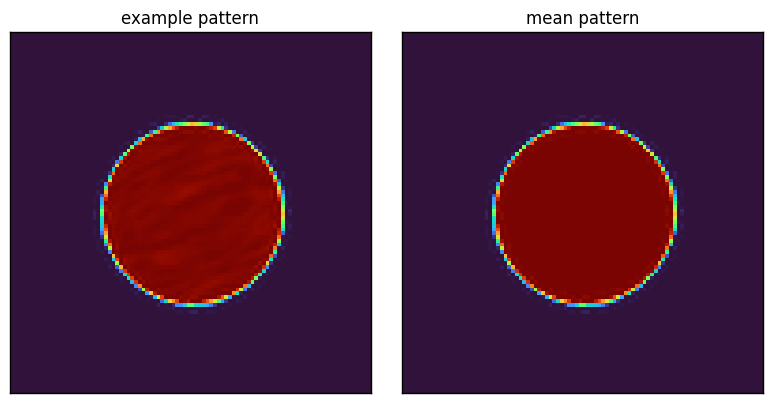

In [4]:
em.visualization.show_2d(
    [
        dataset[0,0].array,
        dataset.mean((0,1)),
    ],
    title=[
        "example pattern","mean pattern"
    ],
    power=0.5,
    cmap='turbo'
);

In [6]:
direct_ptycho = em.diffractive_imaging.DirectPtychography.from_dataset4d(
    dataset,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    rotation_angle=rotation_angle,
    aberration_coefs=aberration_coefs,
    device='gpu',
)

  0%|          | 0/6 [00:00<?, ?it/s]

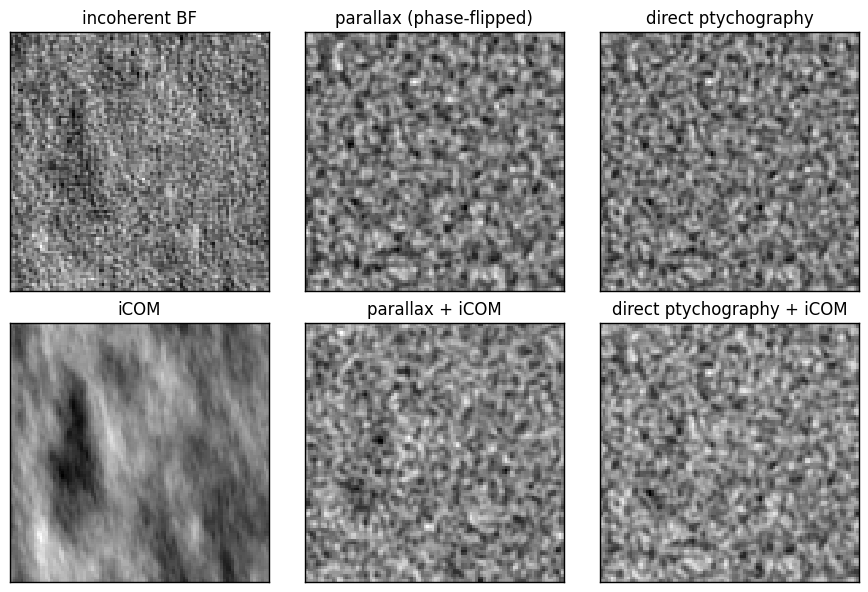

In [7]:
kwargs = {
    "title":[
        ["incoherent BF","parallax (phase-flipped)","direct ptychography",],
        ["iCOM","parallax + iCOM", "direct ptychography + iCOM"]
    ],
    "norm":"minmax",
    "axsize":(3,3),
}

recons = direct_ptycho._reconstruct_all_permutations(
)

em.visualization.show_2d(
    [
        recons[:3],
        recons[3:],
    ],
    **kwargs
);

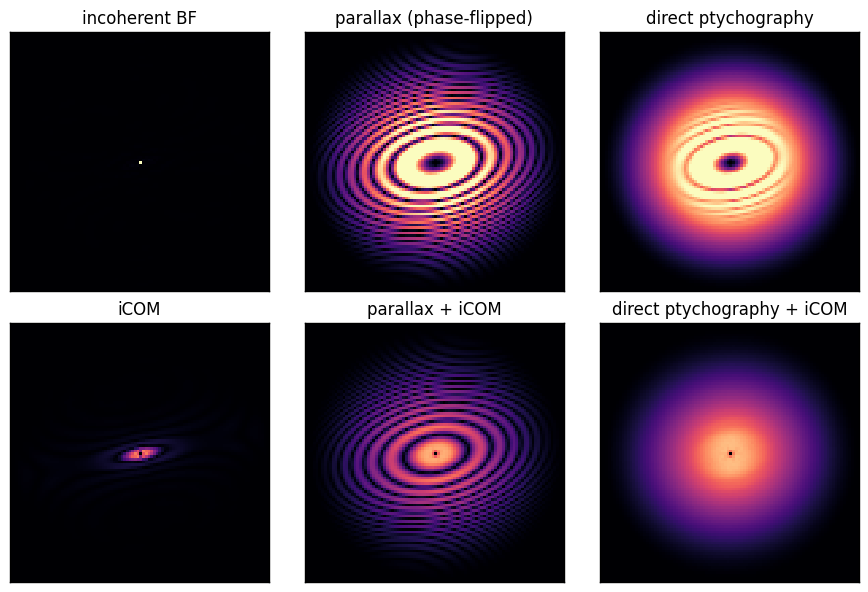

In [9]:
fft_recons = [np.fft.fftshift(np.abs(np.fft.fft2(recon))) for recon in recons]
fft_kwargs = kwargs.copy()
fft_kwargs['cmap'] = "magma"
fft_kwargs['norm'] = em.visualization.NormalizationConfig(
    interval_type="manual",
    vmin=0,
    vmax=1
)

em.visualization.show_2d(
    [
        fft_recons[:3],
        fft_recons[3:],
    ],
    **fft_kwargs
);

  0%|          | 0/150 [00:00<?, ?it/s]

Optimized parameters: {'C10': 195.55813382024107, 'C12': 108.81468043082924, 'phi12': 0.13835013828791912, 'rotation_angle': -0.28561515339409227}


  0%|          | 0/1791 [00:00<?, ?it/s]

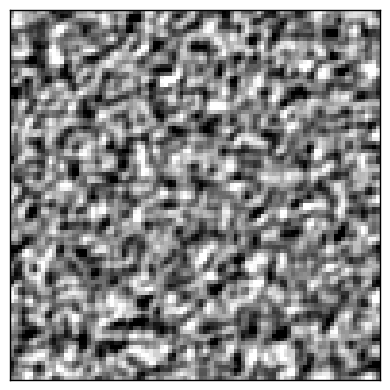

In [12]:
# Optimize aberrations and rotation with optuna
direct_ptycho = direct_ptycho.optimize_hyperparameters(
    aberration_coefs={
        "C10":em.diffractive_imaging.direct_ptychography.OptimizationParameter(0,500),
        "C12":em.diffractive_imaging.direct_ptychography.OptimizationParameter(0,500),
        "phi12":em.diffractive_imaging.direct_ptychography.OptimizationParameter(-0.5,0.5)
    },
    rotation_angle=em.diffractive_imaging.direct_ptychography.OptimizationParameter(-0.5,0.5),
    n_trials=200,
    deconvolution_kernel='parallax',
)

em.visualization.show_2d(
    direct_ptycho.reconstruct_with_optimized_parameters(
        deconvolution_kernel='full',
    ).obj
);

Aligning (reference):   0%|          | 0/3 [00:00<?, ?it/s]

Fitted parameters: {'C10': 216.04974365234375, 'C12': 100.53048706054688, 'phi12': 0.18286380171775818, 'rotation_angle': -0.22620493173599243}


  0%|          | 0/1791 [00:00<?, ?it/s]

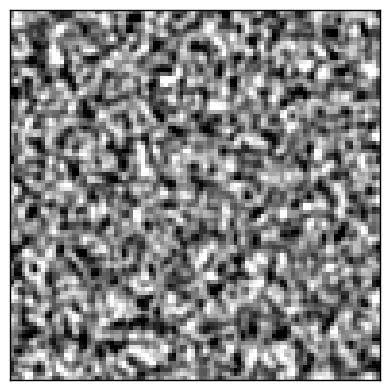

In [15]:
# reference fit from decent guess 
direct_ptycho.fit_hyperparameters(
    alignment_method='reference',
    bin_factors=(1,1,1),

    aberration_coefs = {"C10":150},
    rotation_angle= -0.2,
);

em.visualization.show_2d(
    direct_ptycho.reconstruct_with_fitted_parameters(
        deconvolution_kernel='full',
    ).obj
);